# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

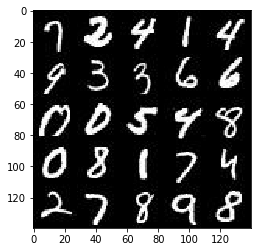

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

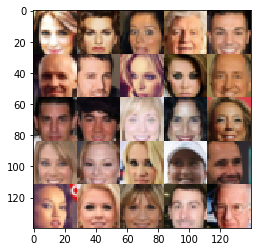

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    i_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, (None, z_dim))
    lr      = tf.placeholder(tf.float32)
    return i_input, z_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    # similar to previous execise
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3     
        x2 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 14x14x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # similar to previous execise, but different image size, one layer less
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
    
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    output_dim = out_channel_dim
    alpha = 0.2
    g_model = generator(input_z, output_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import matplotlib.pyplot as plt
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    
    
    steps = 0
    print_every = 10
    show_every  = 50
    # extract image format
    image_height = data_shape[1]
    image_width = data_shape[2]
    image_channels = 1
    if data_image_mode == "RGB":
        image_channels = 3
    losses = []
    # rest straight forward from last execise:
    input_i, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_i, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_i: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_i: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_i: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "d_loss: {:.4f}...".format(train_loss_d),
                          "g_loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                    

    fig, ax = plt.subplots()
    losses = np.array(losses)
    plt.plot(losses.T[0], label='Discriminator')
    plt.plot(losses.T[1], label='Generator')
    plt.title("Training Losses")
    plt.legend()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... d_loss: 0.1987... g_loss: 7.7451
Epoch 1/2... d_loss: 3.7916... g_loss: 3.7487
Epoch 1/2... d_loss: 2.1975... g_loss: 3.6845
Epoch 1/2... d_loss: 2.1154... g_loss: 4.6872
Epoch 1/2... d_loss: 1.9276... g_loss: 3.8699


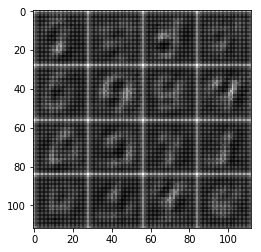

Epoch 1/2... d_loss: 2.3305... g_loss: 4.2908
Epoch 1/2... d_loss: 1.8981... g_loss: 4.1753
Epoch 1/2... d_loss: 2.0011... g_loss: 4.4742
Epoch 1/2... d_loss: 1.5564... g_loss: 3.2972
Epoch 1/2... d_loss: 1.3548... g_loss: 3.8736


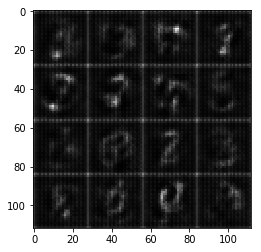

Epoch 1/2... d_loss: 1.3199... g_loss: 3.8784
Epoch 1/2... d_loss: 1.0449... g_loss: 4.8162
Epoch 1/2... d_loss: 1.5513... g_loss: 3.8948
Epoch 1/2... d_loss: 0.9548... g_loss: 4.1366
Epoch 1/2... d_loss: 1.3802... g_loss: 6.5456


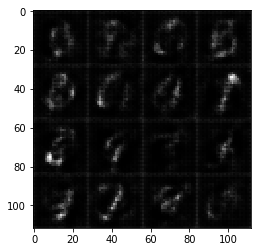

Epoch 1/2... d_loss: 0.3834... g_loss: 4.4308
Epoch 1/2... d_loss: 1.8523... g_loss: 5.5235
Epoch 1/2... d_loss: 1.4760... g_loss: 5.7438
Epoch 1/2... d_loss: 0.1869... g_loss: 2.0055
Epoch 1/2... d_loss: 1.5112... g_loss: 0.2907


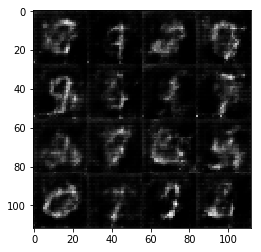

Epoch 1/2... d_loss: 2.1047... g_loss: 0.1700
Epoch 1/2... d_loss: 1.5795... g_loss: 0.2772
Epoch 1/2... d_loss: 0.2540... g_loss: 1.8781
Epoch 1/2... d_loss: 0.1590... g_loss: 2.5315
Epoch 1/2... d_loss: 0.1268... g_loss: 2.4792


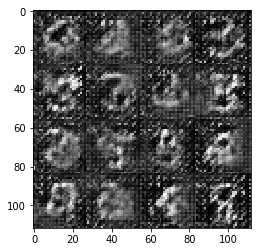

Epoch 1/2... d_loss: 0.1170... g_loss: 3.1871
Epoch 1/2... d_loss: 0.0470... g_loss: 3.8220
Epoch 1/2... d_loss: 0.1408... g_loss: 2.2742
Epoch 1/2... d_loss: 0.0245... g_loss: 7.5139
Epoch 1/2... d_loss: 14.3156... g_loss: 17.1220


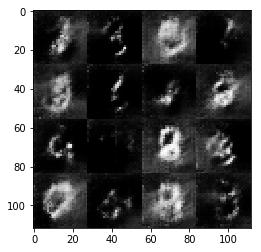

Epoch 1/2... d_loss: 2.2074... g_loss: 7.3967
Epoch 1/2... d_loss: 2.3522... g_loss: 6.4334
Epoch 1/2... d_loss: 0.2324... g_loss: 2.6560
Epoch 1/2... d_loss: 0.1541... g_loss: 2.6248
Epoch 1/2... d_loss: 0.0477... g_loss: 4.0022


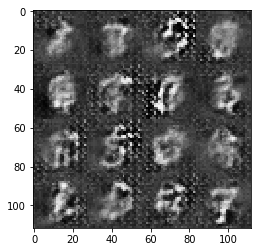

Epoch 1/2... d_loss: 0.0812... g_loss: 3.0965
Epoch 1/2... d_loss: 0.1696... g_loss: 4.4557
Epoch 1/2... d_loss: 0.0709... g_loss: 3.3440
Epoch 1/2... d_loss: 0.0604... g_loss: 3.2677
Epoch 1/2... d_loss: 0.0517... g_loss: 3.6801


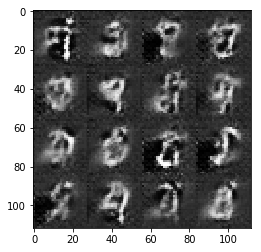

Epoch 1/2... d_loss: 0.0302... g_loss: 5.5853
Epoch 1/2... d_loss: 3.3190... g_loss: 0.0782
Epoch 1/2... d_loss: 1.2763... g_loss: 0.5812
Epoch 1/2... d_loss: 0.5461... g_loss: 1.1020
Epoch 1/2... d_loss: 0.2276... g_loss: 2.2664


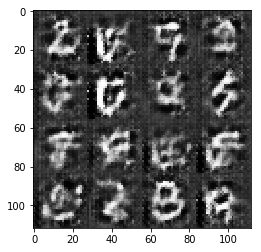

Epoch 1/2... d_loss: 0.1627... g_loss: 2.8401
Epoch 2/2... d_loss: 0.2458... g_loss: 2.6111
Epoch 2/2... d_loss: 1.1446... g_loss: 1.8715
Epoch 2/2... d_loss: 0.3606... g_loss: 2.0460
Epoch 2/2... d_loss: 0.4003... g_loss: 2.3178


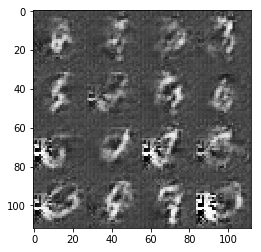

Epoch 2/2... d_loss: 0.1086... g_loss: 8.5051
Epoch 2/2... d_loss: 0.0563... g_loss: 6.5993
Epoch 2/2... d_loss: 3.4279... g_loss: 4.1631
Epoch 2/2... d_loss: 1.7705... g_loss: 6.5917
Epoch 2/2... d_loss: 0.8505... g_loss: 5.6724


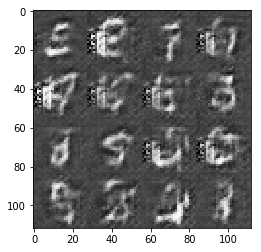

Epoch 2/2... d_loss: 0.1350... g_loss: 3.1295
Epoch 2/2... d_loss: 4.3283... g_loss: 0.0296
Epoch 2/2... d_loss: 2.0430... g_loss: 0.2000
Epoch 2/2... d_loss: 1.9099... g_loss: 0.2119
Epoch 2/2... d_loss: 1.6196... g_loss: 0.3068


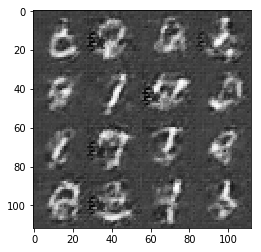

Epoch 2/2... d_loss: 0.3759... g_loss: 1.5627
Epoch 2/2... d_loss: 0.9585... g_loss: 0.6842
Epoch 2/2... d_loss: 0.2105... g_loss: 3.0125
Epoch 2/2... d_loss: 0.4750... g_loss: 5.2579
Epoch 2/2... d_loss: 0.1675... g_loss: 2.7706


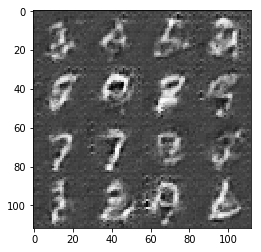

Epoch 2/2... d_loss: 3.0461... g_loss: 0.0741
Epoch 2/2... d_loss: 2.3107... g_loss: 0.1395
Epoch 2/2... d_loss: 0.3180... g_loss: 1.7975
Epoch 2/2... d_loss: 0.6666... g_loss: 0.9591
Epoch 2/2... d_loss: 1.9480... g_loss: 0.1958


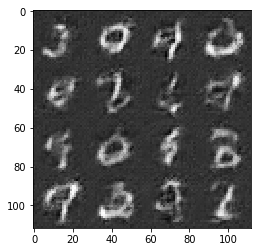

Epoch 2/2... d_loss: 0.8073... g_loss: 0.7067
Epoch 2/2... d_loss: 0.2445... g_loss: 1.9135
Epoch 2/2... d_loss: 1.1160... g_loss: 0.6599
Epoch 2/2... d_loss: 1.1740... g_loss: 0.4870
Epoch 2/2... d_loss: 2.0296... g_loss: 0.1735


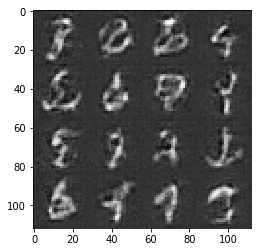

Epoch 2/2... d_loss: 0.4698... g_loss: 1.2176
Epoch 2/2... d_loss: 0.1592... g_loss: 2.8369
Epoch 2/2... d_loss: 0.0842... g_loss: 3.4392
Epoch 2/2... d_loss: 0.0781... g_loss: 4.0895
Epoch 2/2... d_loss: 0.0709... g_loss: 3.6610


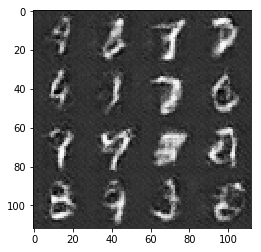

Epoch 2/2... d_loss: 0.0903... g_loss: 3.5487
Epoch 2/2... d_loss: 0.5416... g_loss: 4.9417
Epoch 2/2... d_loss: 1.6501... g_loss: 0.3265
Epoch 2/2... d_loss: 0.8907... g_loss: 0.6402
Epoch 2/2... d_loss: 1.3764... g_loss: 0.3727


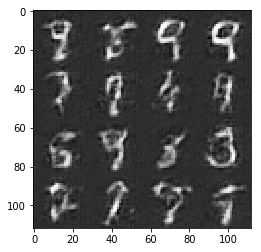

Epoch 2/2... d_loss: 1.7437... g_loss: 0.2312
Epoch 2/2... d_loss: 0.3251... g_loss: 1.6096
Epoch 2/2... d_loss: 0.1952... g_loss: 2.2979
Epoch 2/2... d_loss: 0.1365... g_loss: 2.8611
Epoch 2/2... d_loss: 0.0853... g_loss: 3.3322


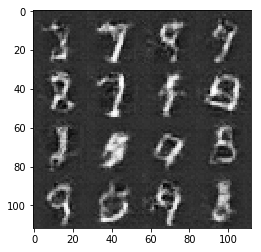

Epoch 2/2... d_loss: 0.1242... g_loss: 2.6805
Epoch 2/2... d_loss: 0.0944... g_loss: 3.7198
Epoch 2/2... d_loss: 1.4416... g_loss: 3.3608


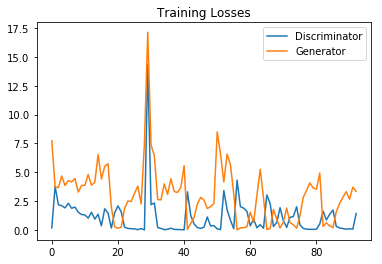

In [ ]:
batch_size = 128
z_dim = 32
learning_rate = 0.001
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... d_loss: 1.7130... g_loss: 15.3392
Epoch 1/3... d_loss: 5.0833... g_loss: 6.3035
Epoch 1/3... d_loss: 2.7774... g_loss: 4.7722
Epoch 1/3... d_loss: 3.3322... g_loss: 5.3225
Epoch 1/3... d_loss: 2.3283... g_loss: 2.8023


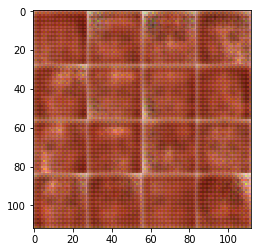

Epoch 1/3... d_loss: 2.5334... g_loss: 4.9470
Epoch 1/3... d_loss: 2.7685... g_loss: 4.5565
Epoch 1/3... d_loss: 2.1516... g_loss: 5.0240
Epoch 1/3... d_loss: 2.5173... g_loss: 4.8812
Epoch 1/3... d_loss: 1.1870... g_loss: 4.0166


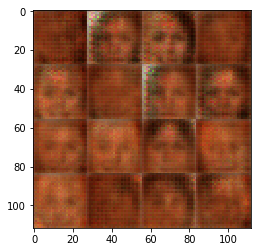

Epoch 1/3... d_loss: 1.3313... g_loss: 0.4583
Epoch 1/3... d_loss: 2.7915... g_loss: 0.0966
Epoch 1/3... d_loss: 3.0832... g_loss: 0.0746
Epoch 1/3... d_loss: 2.6189... g_loss: 0.1003
Epoch 1/3... d_loss: 1.7771... g_loss: 0.2552


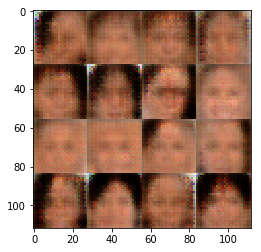

Epoch 1/3... d_loss: 1.0630... g_loss: 0.5405
Epoch 1/3... d_loss: 1.2021... g_loss: 0.4845
Epoch 1/3... d_loss: 1.9610... g_loss: 0.2174
Epoch 1/3... d_loss: 1.8568... g_loss: 0.2019
Epoch 1/3... d_loss: 1.3669... g_loss: 0.3573


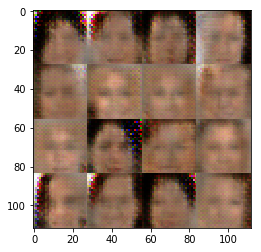

Epoch 1/3... d_loss: 0.8777... g_loss: 0.8632
Epoch 1/3... d_loss: 1.9923... g_loss: 0.1774
Epoch 1/3... d_loss: 2.1523... g_loss: 0.1567
Epoch 1/3... d_loss: 1.5734... g_loss: 0.3257
Epoch 1/3... d_loss: 1.0083... g_loss: 0.6311


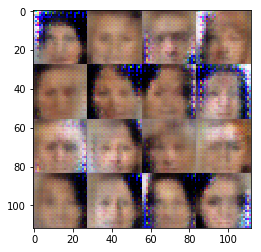

Epoch 1/3... d_loss: 0.6659... g_loss: 0.8611
Epoch 1/3... d_loss: 0.2874... g_loss: 1.6399
Epoch 1/3... d_loss: 0.5938... g_loss: 4.9617
Epoch 1/3... d_loss: 2.6254... g_loss: 0.1151
Epoch 1/3... d_loss: 1.8752... g_loss: 0.2083


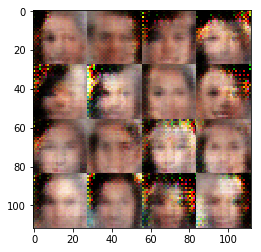

Epoch 1/3... d_loss: 1.3307... g_loss: 0.3685
Epoch 1/3... d_loss: 1.4599... g_loss: 0.3225
Epoch 1/3... d_loss: 0.6291... g_loss: 1.9299
Epoch 1/3... d_loss: 1.5728... g_loss: 0.3815
Epoch 1/3... d_loss: 0.5817... g_loss: 1.0607


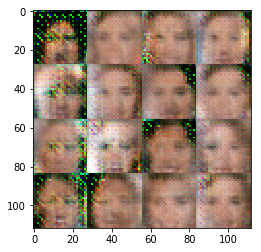

Epoch 1/3... d_loss: 2.0407... g_loss: 0.1721
Epoch 1/3... d_loss: 1.5579... g_loss: 0.2806
Epoch 1/3... d_loss: 1.1237... g_loss: 0.5206
Epoch 1/3... d_loss: 0.4448... g_loss: 3.4229
Epoch 1/3... d_loss: 0.6625... g_loss: 2.6935


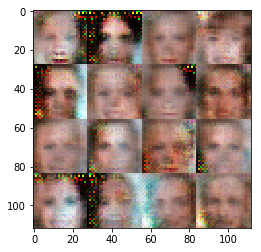

Epoch 1/3... d_loss: 0.2576... g_loss: 1.9171
Epoch 1/3... d_loss: 0.1054... g_loss: 4.1469
Epoch 1/3... d_loss: 0.0545... g_loss: 4.4316
Epoch 1/3... d_loss: 0.0424... g_loss: 4.2898
Epoch 1/3... d_loss: 0.0315... g_loss: 4.4382


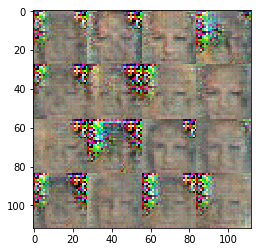

Epoch 1/3... d_loss: 0.0485... g_loss: 3.8371
Epoch 1/3... d_loss: 0.0387... g_loss: 3.7542
Epoch 1/3... d_loss: 0.0257... g_loss: 4.1377
Epoch 1/3... d_loss: 0.0556... g_loss: 3.5382
Epoch 1/3... d_loss: 0.0317... g_loss: 4.1926


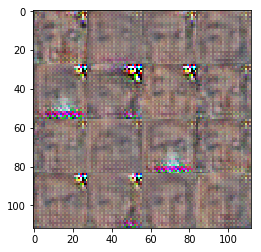

Epoch 1/3... d_loss: 0.0271... g_loss: 4.3188
Epoch 1/3... d_loss: 0.0124... g_loss: 5.7175
Epoch 1/3... d_loss: 0.0102... g_loss: 6.3184
Epoch 1/3... d_loss: 2.3338... g_loss: 6.8769
Epoch 1/3... d_loss: 1.5399... g_loss: 2.8098


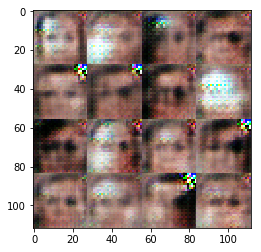

Epoch 1/3... d_loss: 1.5034... g_loss: 2.4146
Epoch 1/3... d_loss: 1.7678... g_loss: 3.1256
Epoch 1/3... d_loss: 2.1695... g_loss: 1.6179
Epoch 1/3... d_loss: 2.1899... g_loss: 0.1828
Epoch 1/3... d_loss: 1.8833... g_loss: 0.2489


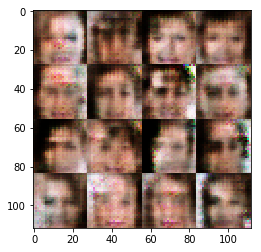

Epoch 1/3... d_loss: 2.0618... g_loss: 0.2137
Epoch 1/3... d_loss: 1.3359... g_loss: 0.9921
Epoch 1/3... d_loss: 1.4332... g_loss: 0.3696
Epoch 1/3... d_loss: 1.4668... g_loss: 0.3287
Epoch 1/3... d_loss: 1.8533... g_loss: 0.2224


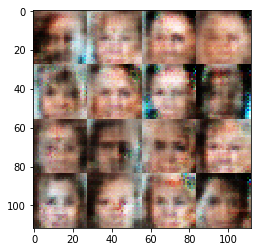

Epoch 1/3... d_loss: 1.1156... g_loss: 0.8375
Epoch 1/3... d_loss: 1.4688... g_loss: 0.6820
Epoch 1/3... d_loss: 1.8365... g_loss: 2.1003
Epoch 1/3... d_loss: 1.4263... g_loss: 1.9076
Epoch 1/3... d_loss: 1.3864... g_loss: 2.0914


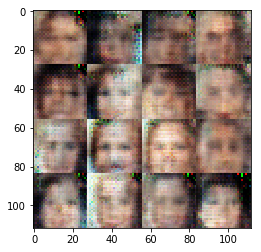

Epoch 1/3... d_loss: 1.3694... g_loss: 1.9537
Epoch 1/3... d_loss: 1.9375... g_loss: 2.2301
Epoch 1/3... d_loss: 1.7994... g_loss: 1.8971
Epoch 1/3... d_loss: 1.3560... g_loss: 1.3753
Epoch 1/3... d_loss: 1.7889... g_loss: 0.5452


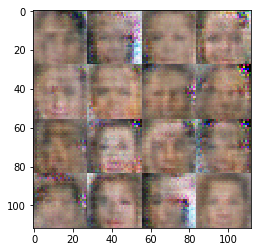

Epoch 1/3... d_loss: 1.3977... g_loss: 0.5052
Epoch 1/3... d_loss: 1.3880... g_loss: 1.1270
Epoch 1/3... d_loss: 1.5641... g_loss: 1.5433
Epoch 1/3... d_loss: 1.5391... g_loss: 1.5753
Epoch 1/3... d_loss: 1.5551... g_loss: 1.3270


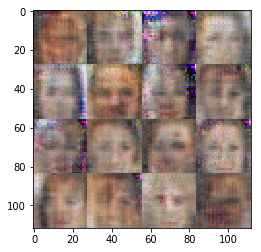

Epoch 1/3... d_loss: 1.1910... g_loss: 0.9630
Epoch 1/3... d_loss: 1.5285... g_loss: 0.3632
Epoch 1/3... d_loss: 1.1966... g_loss: 0.9193
Epoch 1/3... d_loss: 1.6564... g_loss: 0.3109
Epoch 1/3... d_loss: 1.3407... g_loss: 0.5540


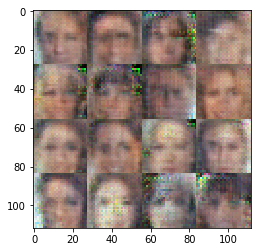

Epoch 1/3... d_loss: 1.4615... g_loss: 0.4179
Epoch 1/3... d_loss: 1.2151... g_loss: 0.7518
Epoch 1/3... d_loss: 1.1417... g_loss: 1.2663
Epoch 1/3... d_loss: 1.3999... g_loss: 0.4382
Epoch 1/3... d_loss: 1.7383... g_loss: 0.2569


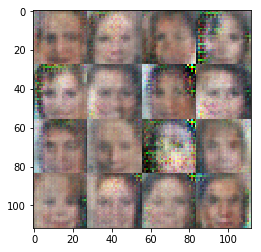

Epoch 1/3... d_loss: 1.4097... g_loss: 0.4114
Epoch 1/3... d_loss: 1.3156... g_loss: 0.5240
Epoch 1/3... d_loss: 1.3647... g_loss: 0.6856
Epoch 1/3... d_loss: 1.4663... g_loss: 0.4677
Epoch 1/3... d_loss: 1.4837... g_loss: 0.3949


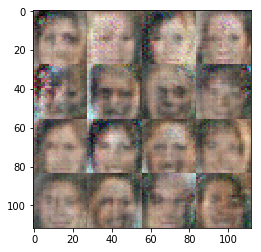

Epoch 1/3... d_loss: 1.5074... g_loss: 0.4599
Epoch 1/3... d_loss: 1.9410... g_loss: 1.6912
Epoch 1/3... d_loss: 1.5270... g_loss: 1.2915
Epoch 1/3... d_loss: 0.9787... g_loss: 1.2928
Epoch 1/3... d_loss: 1.5952... g_loss: 1.3849


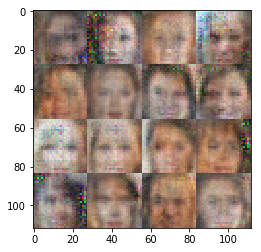

Epoch 1/3... d_loss: 1.4092... g_loss: 1.2139
Epoch 1/3... d_loss: 1.1295... g_loss: 1.1326
Epoch 1/3... d_loss: 1.6838... g_loss: 0.3165
Epoch 1/3... d_loss: 1.3596... g_loss: 0.6914
Epoch 1/3... d_loss: 1.4298... g_loss: 1.8103


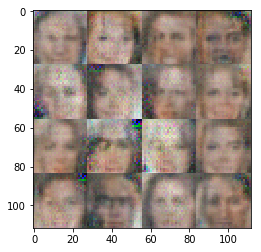

Epoch 1/3... d_loss: 1.1045... g_loss: 0.9203
Epoch 1/3... d_loss: 1.4045... g_loss: 0.9414
Epoch 1/3... d_loss: 1.2895... g_loss: 0.5694
Epoch 1/3... d_loss: 1.2078... g_loss: 0.6888
Epoch 1/3... d_loss: 1.4284... g_loss: 0.4262


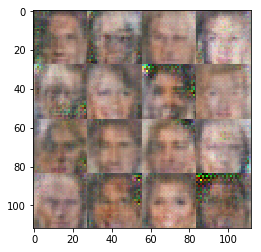

Epoch 1/3... d_loss: 1.1566... g_loss: 1.2454
Epoch 1/3... d_loss: 1.4314... g_loss: 1.1386
Epoch 1/3... d_loss: 1.3087... g_loss: 1.6666
Epoch 1/3... d_loss: 1.2926... g_loss: 1.4421
Epoch 1/3... d_loss: 1.1249... g_loss: 0.9126


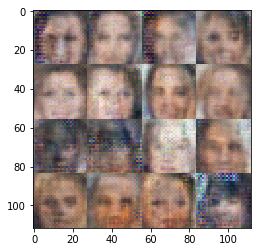

Epoch 1/3... d_loss: 1.5303... g_loss: 1.0534
Epoch 1/3... d_loss: 1.3402... g_loss: 0.5524
Epoch 1/3... d_loss: 1.6114... g_loss: 0.3134
Epoch 1/3... d_loss: 1.3371... g_loss: 1.2584
Epoch 1/3... d_loss: 1.5717... g_loss: 1.0512


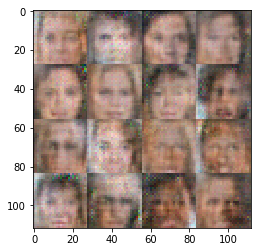

Epoch 1/3... d_loss: 1.4697... g_loss: 0.8587
Epoch 1/3... d_loss: 1.4071... g_loss: 0.9156
Epoch 1/3... d_loss: 1.4501... g_loss: 1.0057
Epoch 1/3... d_loss: 1.1850... g_loss: 0.9314
Epoch 1/3... d_loss: 1.6499... g_loss: 0.3360


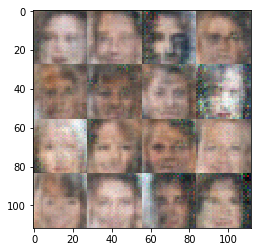

Epoch 1/3... d_loss: 1.4506... g_loss: 0.5981
Epoch 1/3... d_loss: 1.2768... g_loss: 1.1575
Epoch 1/3... d_loss: 1.3667... g_loss: 0.9067
Epoch 1/3... d_loss: 1.5797... g_loss: 0.4017
Epoch 1/3... d_loss: 1.5119... g_loss: 0.4615


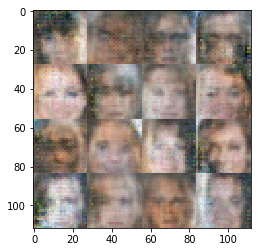

Epoch 1/3... d_loss: 1.2094... g_loss: 1.0508
Epoch 1/3... d_loss: 1.2084... g_loss: 0.8894
Epoch 1/3... d_loss: 1.4404... g_loss: 1.0993
Epoch 1/3... d_loss: 1.3455... g_loss: 0.5589
Epoch 1/3... d_loss: 1.7679... g_loss: 0.2443


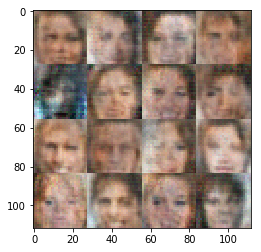

Epoch 1/3... d_loss: 1.6741... g_loss: 0.2952
Epoch 1/3... d_loss: 1.2451... g_loss: 0.7197
Epoch 1/3... d_loss: 1.3955... g_loss: 1.0009
Epoch 1/3... d_loss: 1.4681... g_loss: 0.4247
Epoch 1/3... d_loss: 1.2549... g_loss: 1.5381


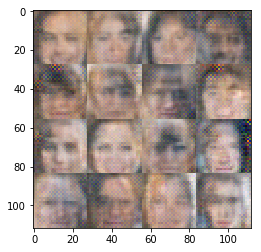

Epoch 1/3... d_loss: 1.3164... g_loss: 0.9563
Epoch 1/3... d_loss: 1.4835... g_loss: 0.6639
Epoch 1/3... d_loss: 1.3959... g_loss: 0.6337
Epoch 1/3... d_loss: 1.4431... g_loss: 0.7880
Epoch 1/3... d_loss: 1.4325... g_loss: 0.5634


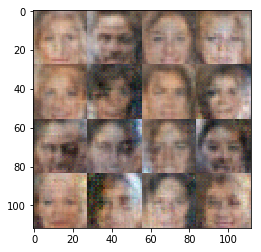

Epoch 1/3... d_loss: 1.3357... g_loss: 0.7750
Epoch 1/3... d_loss: 1.3380... g_loss: 0.7382
Epoch 1/3... d_loss: 1.4436... g_loss: 0.7884
Epoch 1/3... d_loss: 1.3584... g_loss: 0.7200
Epoch 1/3... d_loss: 1.4150... g_loss: 0.7357


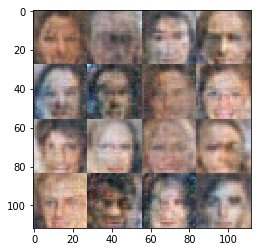

Epoch 1/3... d_loss: 1.3398... g_loss: 0.7572
Epoch 1/3... d_loss: 1.3423... g_loss: 0.7048
Epoch 1/3... d_loss: 1.3424... g_loss: 0.8361
Epoch 1/3... d_loss: 1.3505... g_loss: 0.7191
Epoch 1/3... d_loss: 1.4043... g_loss: 0.9622


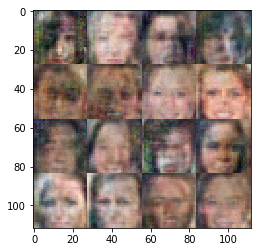

Epoch 1/3... d_loss: 1.3774... g_loss: 1.0014
Epoch 1/3... d_loss: 1.3803... g_loss: 0.9386
Epoch 1/3... d_loss: 1.3859... g_loss: 0.7797
Epoch 2/3... d_loss: 1.3285... g_loss: 0.8380
Epoch 2/3... d_loss: 1.4083... g_loss: 0.9118


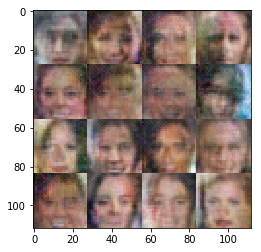

Epoch 2/3... d_loss: 1.3457... g_loss: 0.7640
Epoch 2/3... d_loss: 1.6829... g_loss: 0.4980
Epoch 2/3... d_loss: 1.4146... g_loss: 0.5737
Epoch 2/3... d_loss: 1.3229... g_loss: 0.8149
Epoch 2/3... d_loss: 1.3607... g_loss: 1.0202


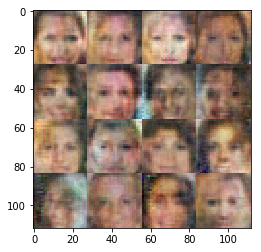

Epoch 2/3... d_loss: 1.3992... g_loss: 0.8800
Epoch 2/3... d_loss: 1.5801... g_loss: 1.2321
Epoch 2/3... d_loss: 1.4460... g_loss: 0.9546
Epoch 2/3... d_loss: 1.3765... g_loss: 0.8227
Epoch 2/3... d_loss: 1.4269... g_loss: 0.6449


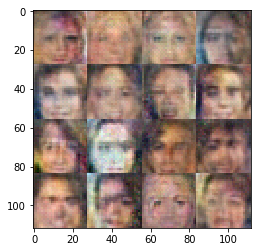

Epoch 2/3... d_loss: 1.3847... g_loss: 0.7610
Epoch 2/3... d_loss: 1.3663... g_loss: 0.7993
Epoch 2/3... d_loss: 1.4745... g_loss: 0.9245
Epoch 2/3... d_loss: 1.3538... g_loss: 0.7507
Epoch 2/3... d_loss: 1.3803... g_loss: 0.9004


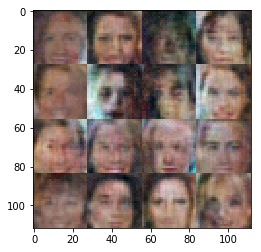

Epoch 2/3... d_loss: 1.3560... g_loss: 0.7610
Epoch 2/3... d_loss: 1.3882... g_loss: 0.9120
Epoch 2/3... d_loss: 1.3801... g_loss: 0.7435
Epoch 2/3... d_loss: 1.3822... g_loss: 0.8560
Epoch 2/3... d_loss: 1.3734... g_loss: 0.6729


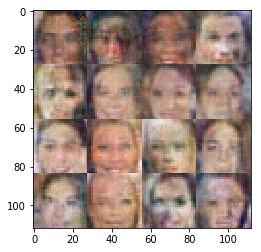

Epoch 2/3... d_loss: 1.4071... g_loss: 0.8111
Epoch 2/3... d_loss: 1.2853... g_loss: 0.6883
Epoch 2/3... d_loss: 1.4521... g_loss: 0.5588
Epoch 2/3... d_loss: 1.3809... g_loss: 0.8419
Epoch 2/3... d_loss: 1.3690... g_loss: 0.5280


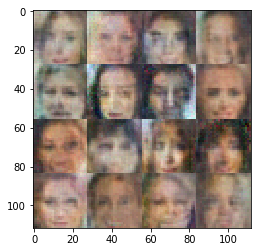

Epoch 2/3... d_loss: 1.3498... g_loss: 0.7013
Epoch 2/3... d_loss: 1.3269... g_loss: 0.6849
Epoch 2/3... d_loss: 1.3896... g_loss: 0.5902
Epoch 2/3... d_loss: 1.3945... g_loss: 0.7310
Epoch 2/3... d_loss: 1.3470... g_loss: 0.7562


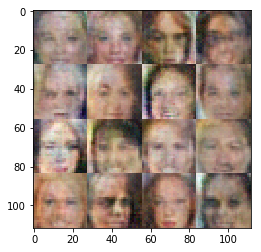

Epoch 2/3... d_loss: 1.4341... g_loss: 0.9918
Epoch 2/3... d_loss: 1.3786... g_loss: 0.8891
Epoch 2/3... d_loss: 1.3514... g_loss: 0.7453
Epoch 2/3... d_loss: 1.4053... g_loss: 0.5636
Epoch 2/3... d_loss: 1.3019... g_loss: 1.1350


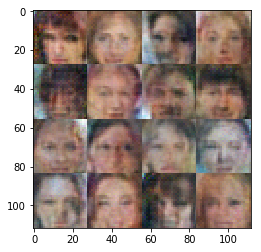

Epoch 2/3... d_loss: 1.3969... g_loss: 0.4967
Epoch 2/3... d_loss: 1.4255... g_loss: 0.6036
Epoch 2/3... d_loss: 1.4255... g_loss: 0.5346
Epoch 2/3... d_loss: 1.1812... g_loss: 0.9413
Epoch 2/3... d_loss: 1.3952... g_loss: 1.2438


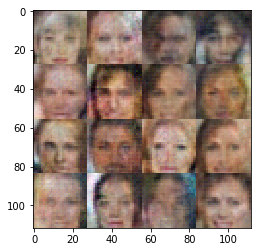

Epoch 2/3... d_loss: 1.3791... g_loss: 0.6183
Epoch 2/3... d_loss: 0.9775... g_loss: 0.7729
Epoch 2/3... d_loss: 1.3132... g_loss: 0.6018
Epoch 2/3... d_loss: 1.2509... g_loss: 0.8326
Epoch 2/3... d_loss: 1.5116... g_loss: 0.4279


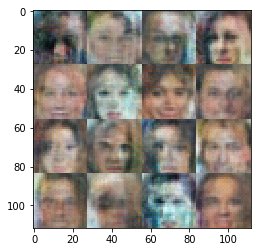

Epoch 2/3... d_loss: 1.3749... g_loss: 0.6410
Epoch 2/3... d_loss: 1.3817... g_loss: 0.6160
Epoch 2/3... d_loss: 1.3989... g_loss: 0.7040
Epoch 2/3... d_loss: 1.3886... g_loss: 0.8017
Epoch 2/3... d_loss: 1.3183... g_loss: 0.8782


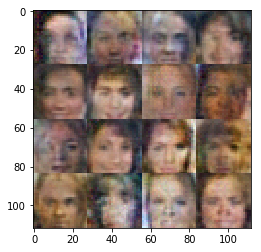

Epoch 2/3... d_loss: 1.4332... g_loss: 0.4687
Epoch 2/3... d_loss: 1.3565... g_loss: 0.7525
Epoch 2/3... d_loss: 1.4010... g_loss: 0.9155
Epoch 2/3... d_loss: 1.3782... g_loss: 0.8046
Epoch 2/3... d_loss: 1.4059... g_loss: 0.7076


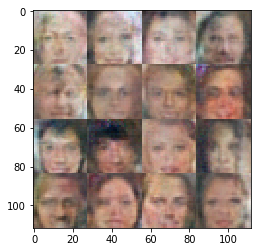

Epoch 2/3... d_loss: 1.3627... g_loss: 0.5918
Epoch 2/3... d_loss: 1.3634... g_loss: 0.8109
Epoch 2/3... d_loss: 1.3608... g_loss: 0.9304
Epoch 2/3... d_loss: 1.4094... g_loss: 0.9910
Epoch 2/3... d_loss: 1.3258... g_loss: 0.6229


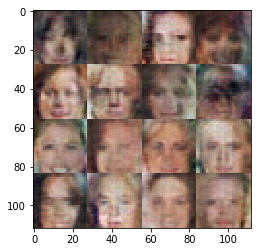

Epoch 2/3... d_loss: 1.3381... g_loss: 0.6707
Epoch 2/3... d_loss: 1.3849... g_loss: 1.0404
Epoch 2/3... d_loss: 1.3640... g_loss: 0.7729
Epoch 2/3... d_loss: 1.3788... g_loss: 0.7367
Epoch 2/3... d_loss: 1.3351... g_loss: 0.6948


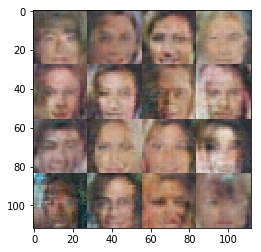

Epoch 2/3... d_loss: 1.4156... g_loss: 0.5626
Epoch 2/3... d_loss: 1.4746... g_loss: 0.4349
Epoch 2/3... d_loss: 1.4528... g_loss: 0.4506
Epoch 2/3... d_loss: 1.4031... g_loss: 0.5581
Epoch 2/3... d_loss: 1.3506... g_loss: 0.6867


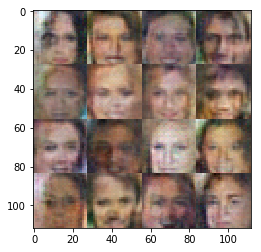

Epoch 2/3... d_loss: 1.2466... g_loss: 0.7279
Epoch 2/3... d_loss: 1.4038... g_loss: 0.5358
Epoch 2/3... d_loss: 1.5510... g_loss: 0.8264
Epoch 2/3... d_loss: 1.5252... g_loss: 0.4076
Epoch 2/3... d_loss: 1.4079... g_loss: 0.6960


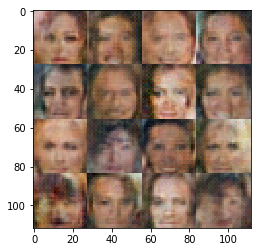

Epoch 2/3... d_loss: 1.4466... g_loss: 0.3924
Epoch 2/3... d_loss: 1.4005... g_loss: 0.4667
Epoch 2/3... d_loss: 1.4711... g_loss: 0.4773
Epoch 2/3... d_loss: 1.3399... g_loss: 0.9911
Epoch 2/3... d_loss: 1.4050... g_loss: 0.9989


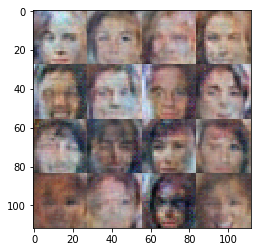

Epoch 2/3... d_loss: 1.4236... g_loss: 0.7806
Epoch 2/3... d_loss: 1.2857... g_loss: 1.0342
Epoch 2/3... d_loss: 1.4850... g_loss: 1.0066
Epoch 2/3... d_loss: 1.4234... g_loss: 0.8589
Epoch 2/3... d_loss: 1.4092... g_loss: 0.7012


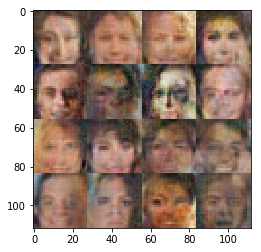

Epoch 2/3... d_loss: 1.3552... g_loss: 0.8262
Epoch 2/3... d_loss: 1.3750... g_loss: 0.7019
Epoch 2/3... d_loss: 1.3758... g_loss: 0.9195
Epoch 2/3... d_loss: 1.3614... g_loss: 0.8052
Epoch 2/3... d_loss: 1.3697... g_loss: 0.8451


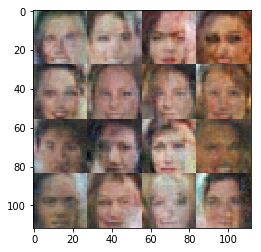

Epoch 2/3... d_loss: 1.4373... g_loss: 0.9659
Epoch 2/3... d_loss: 1.4267... g_loss: 0.8423
Epoch 2/3... d_loss: 1.3572... g_loss: 0.6482
Epoch 2/3... d_loss: 1.3669... g_loss: 0.5849
Epoch 2/3... d_loss: 1.3429... g_loss: 0.6891


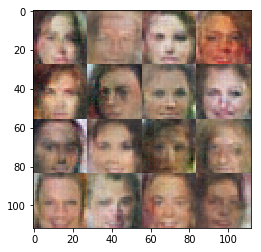

Epoch 2/3... d_loss: 1.3041... g_loss: 0.7221
Epoch 2/3... d_loss: 1.3749... g_loss: 0.6781
Epoch 2/3... d_loss: 1.5706... g_loss: 1.2668
Epoch 2/3... d_loss: 1.3240... g_loss: 0.9613
Epoch 2/3... d_loss: 1.3966... g_loss: 0.8614


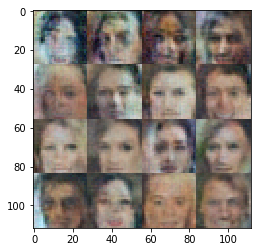

Epoch 2/3... d_loss: 1.2964... g_loss: 1.5006
Epoch 2/3... d_loss: 1.4210... g_loss: 1.4274
Epoch 2/3... d_loss: 1.3887... g_loss: 0.9627
Epoch 2/3... d_loss: 1.3803... g_loss: 0.6977
Epoch 2/3... d_loss: 1.3980... g_loss: 0.9318


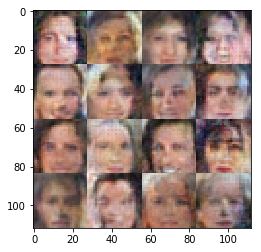

Epoch 2/3... d_loss: 1.3847... g_loss: 0.9318
Epoch 2/3... d_loss: 1.3997... g_loss: 0.8627
Epoch 2/3... d_loss: 1.3727... g_loss: 0.7935
Epoch 2/3... d_loss: 1.4048... g_loss: 0.8719
Epoch 2/3... d_loss: 1.3545... g_loss: 0.8235


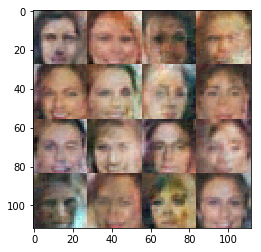

Epoch 2/3... d_loss: 1.3694... g_loss: 0.7048
Epoch 2/3... d_loss: 1.3428... g_loss: 0.7089
Epoch 2/3... d_loss: 1.3723... g_loss: 0.5617
Epoch 2/3... d_loss: 1.3156... g_loss: 0.7287
Epoch 2/3... d_loss: 1.3678... g_loss: 0.6320


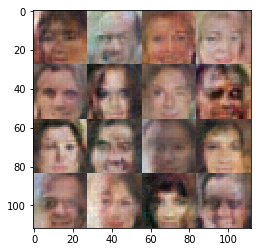

Epoch 2/3... d_loss: 1.3769... g_loss: 0.7031
Epoch 2/3... d_loss: 1.4089... g_loss: 0.4991
Epoch 2/3... d_loss: 1.4080... g_loss: 0.5375
Epoch 2/3... d_loss: 1.3564... g_loss: 0.7111
Epoch 2/3... d_loss: 1.3468... g_loss: 0.6543


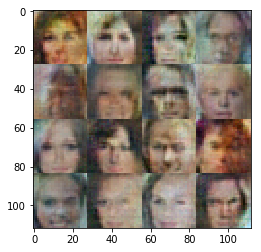

Epoch 2/3... d_loss: 1.3436... g_loss: 0.8280
Epoch 2/3... d_loss: 1.4003... g_loss: 0.9665
Epoch 2/3... d_loss: 1.3890... g_loss: 0.7882
Epoch 2/3... d_loss: 1.3398... g_loss: 0.6666
Epoch 2/3... d_loss: 1.3692... g_loss: 0.7464


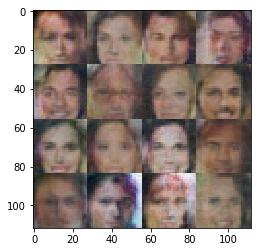

Epoch 2/3... d_loss: 1.3780... g_loss: 0.7700
Epoch 2/3... d_loss: 1.3698... g_loss: 0.8051
Epoch 2/3... d_loss: 1.5206... g_loss: 1.0152
Epoch 2/3... d_loss: 1.3516... g_loss: 0.7847
Epoch 2/3... d_loss: 1.3553... g_loss: 0.8536


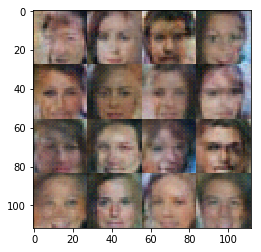

Epoch 2/3... d_loss: 1.3606... g_loss: 0.8383
Epoch 2/3... d_loss: 1.4355... g_loss: 0.9063
Epoch 2/3... d_loss: 1.3587... g_loss: 0.7899
Epoch 2/3... d_loss: 1.3473... g_loss: 0.6435
Epoch 2/3... d_loss: 1.4263... g_loss: 0.7883


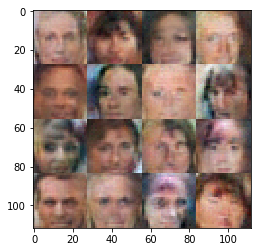

Epoch 2/3... d_loss: 1.3899... g_loss: 0.5233
Epoch 2/3... d_loss: 1.3435... g_loss: 0.7525
Epoch 2/3... d_loss: 1.3476... g_loss: 0.6455
Epoch 2/3... d_loss: 1.3539... g_loss: 0.6478
Epoch 2/3... d_loss: 1.4241... g_loss: 0.4879


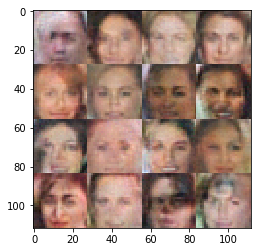

Epoch 2/3... d_loss: 1.3699... g_loss: 0.5895
Epoch 2/3... d_loss: 1.3772... g_loss: 0.6402
Epoch 2/3... d_loss: 1.3944... g_loss: 0.8109
Epoch 2/3... d_loss: 1.3935... g_loss: 0.6336
Epoch 2/3... d_loss: 1.3824... g_loss: 0.5928


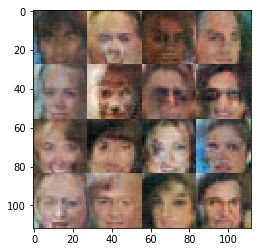

Epoch 2/3... d_loss: 1.3764... g_loss: 0.7584
Epoch 2/3... d_loss: 1.4972... g_loss: 1.0615
Epoch 2/3... d_loss: 1.3562... g_loss: 0.9716
Epoch 2/3... d_loss: 1.3694... g_loss: 0.9290
Epoch 2/3... d_loss: 1.3931... g_loss: 0.8432


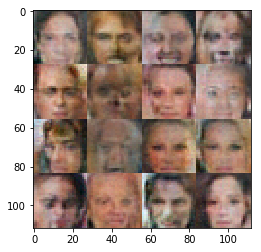

Epoch 2/3... d_loss: 1.4951... g_loss: 0.7821
Epoch 2/3... d_loss: 1.4500... g_loss: 0.4797
Epoch 2/3... d_loss: 1.4776... g_loss: 0.4531
Epoch 2/3... d_loss: 1.3552... g_loss: 0.7057
Epoch 2/3... d_loss: 1.3538... g_loss: 0.7075


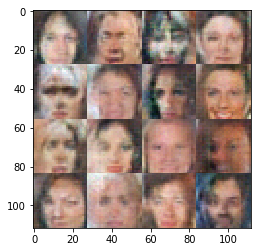

Epoch 2/3... d_loss: 1.4918... g_loss: 1.2377
Epoch 3/3... d_loss: 0.8180... g_loss: 1.0643
Epoch 3/3... d_loss: 1.3608... g_loss: 0.8947
Epoch 3/3... d_loss: 1.3482... g_loss: 0.8522
Epoch 3/3... d_loss: 1.4168... g_loss: 0.9908


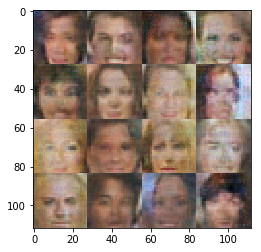

Epoch 3/3... d_loss: 1.3792... g_loss: 0.8230
Epoch 3/3... d_loss: 1.3652... g_loss: 0.8406
Epoch 3/3... d_loss: 1.3524... g_loss: 0.8382
Epoch 3/3... d_loss: 1.3812... g_loss: 0.8611
Epoch 3/3... d_loss: 1.3624... g_loss: 0.7734


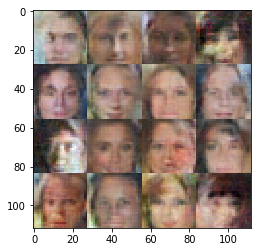

Epoch 3/3... d_loss: 1.3523... g_loss: 0.6287
Epoch 3/3... d_loss: 1.4135... g_loss: 0.5266
Epoch 3/3... d_loss: 1.4212... g_loss: 0.4796
Epoch 3/3... d_loss: 1.3428... g_loss: 0.6001
Epoch 3/3... d_loss: 1.4116... g_loss: 0.5880


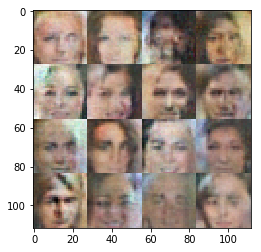

Epoch 3/3... d_loss: 1.3651... g_loss: 0.5639
Epoch 3/3... d_loss: 1.3510... g_loss: 0.6932
Epoch 3/3... d_loss: 1.3380... g_loss: 0.7423
Epoch 3/3... d_loss: 1.3333... g_loss: 0.7053
Epoch 3/3... d_loss: 1.7187... g_loss: 1.2921


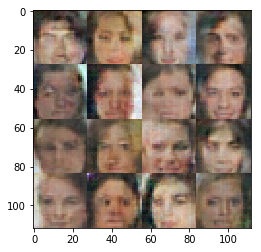

Epoch 3/3... d_loss: 1.4011... g_loss: 0.8139
Epoch 3/3... d_loss: 1.3627... g_loss: 0.7864
Epoch 3/3... d_loss: 1.3232... g_loss: 0.6507
Epoch 3/3... d_loss: 1.4266... g_loss: 0.5872
Epoch 3/3... d_loss: 1.3588... g_loss: 0.6693


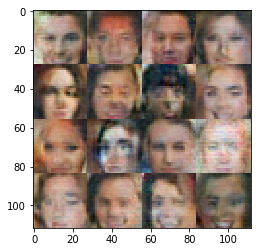

Epoch 3/3... d_loss: 1.3818... g_loss: 0.6027
Epoch 3/3... d_loss: 1.3559... g_loss: 0.6863
Epoch 3/3... d_loss: 1.3882... g_loss: 0.5635
Epoch 3/3... d_loss: 1.3681... g_loss: 0.6477
Epoch 3/3... d_loss: 1.3600... g_loss: 0.7727


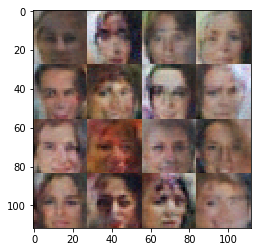

Epoch 3/3... d_loss: 1.3592... g_loss: 0.6592
Epoch 3/3... d_loss: 1.3601... g_loss: 0.6768
Epoch 3/3... d_loss: 1.4256... g_loss: 0.5022
Epoch 3/3... d_loss: 1.4228... g_loss: 0.4909
Epoch 3/3... d_loss: 1.3814... g_loss: 0.5565


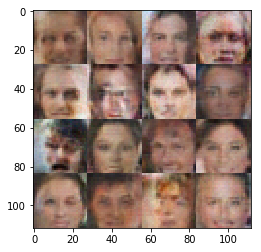

Epoch 3/3... d_loss: 1.4436... g_loss: 0.4633
Epoch 3/3... d_loss: 1.3519... g_loss: 0.6073
Epoch 3/3... d_loss: 1.2834... g_loss: 0.7130
Epoch 3/3... d_loss: 1.3168... g_loss: 0.8448
Epoch 3/3... d_loss: 1.3082... g_loss: 1.0159


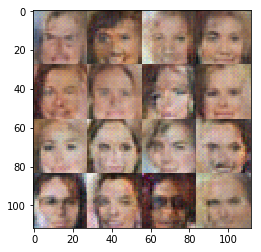

Epoch 3/3... d_loss: 1.0508... g_loss: 0.6786
Epoch 3/3... d_loss: 1.4957... g_loss: 0.4035
Epoch 3/3... d_loss: 1.4272... g_loss: 0.5308
Epoch 3/3... d_loss: 1.3710... g_loss: 0.8111
Epoch 3/3... d_loss: 1.3970... g_loss: 0.5645


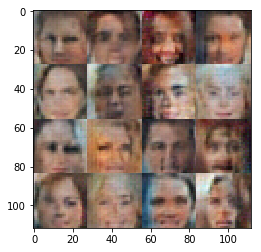

Epoch 3/3... d_loss: 1.3850... g_loss: 0.6341
Epoch 3/3... d_loss: 1.3603... g_loss: 0.6232
Epoch 3/3... d_loss: 1.4022... g_loss: 0.8328
Epoch 3/3... d_loss: 1.4264... g_loss: 0.8576
Epoch 3/3... d_loss: 1.3775... g_loss: 0.7623


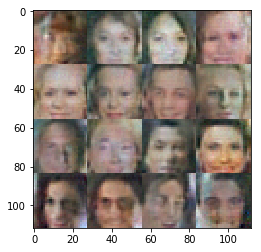

Epoch 3/3... d_loss: 1.3996... g_loss: 0.5742
Epoch 3/3... d_loss: 1.3842... g_loss: 0.8052
Epoch 3/3... d_loss: 1.3483... g_loss: 0.6477
Epoch 3/3... d_loss: 1.3752... g_loss: 0.5534
Epoch 3/3... d_loss: 1.3940... g_loss: 0.5617


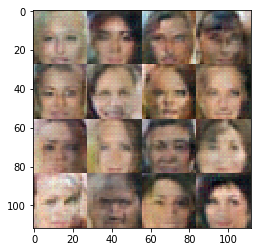

Epoch 3/3... d_loss: 1.3922... g_loss: 0.5780
Epoch 3/3... d_loss: 1.3892... g_loss: 0.5584
Epoch 3/3... d_loss: 1.3585... g_loss: 0.6370
Epoch 3/3... d_loss: 1.3977... g_loss: 0.8286
Epoch 3/3... d_loss: 1.4071... g_loss: 0.9282


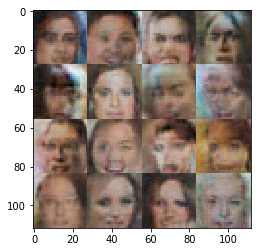

Epoch 3/3... d_loss: 1.4445... g_loss: 0.9325
Epoch 3/3... d_loss: 1.3660... g_loss: 0.8767
Epoch 3/3... d_loss: 1.3691... g_loss: 0.7268
Epoch 3/3... d_loss: 1.3613... g_loss: 0.7367
Epoch 3/3... d_loss: 1.4216... g_loss: 0.9804


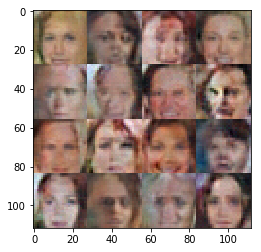

Epoch 3/3... d_loss: 1.3592... g_loss: 0.8590
Epoch 3/3... d_loss: 1.3887... g_loss: 0.7940
Epoch 3/3... d_loss: 1.3518... g_loss: 0.7577
Epoch 3/3... d_loss: 1.3851... g_loss: 0.9703
Epoch 3/3... d_loss: 1.3782... g_loss: 0.8471


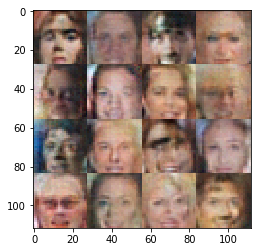

Epoch 3/3... d_loss: 1.4315... g_loss: 0.9939
Epoch 3/3... d_loss: 1.3457... g_loss: 0.7181
Epoch 3/3... d_loss: 1.3525... g_loss: 0.6382
Epoch 3/3... d_loss: 1.3623... g_loss: 0.5700
Epoch 3/3... d_loss: 1.4165... g_loss: 0.5004


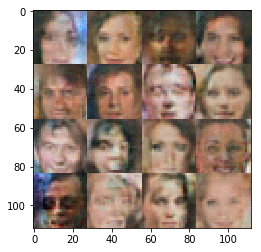

Epoch 3/3... d_loss: 1.3913... g_loss: 0.5714
Epoch 3/3... d_loss: 1.3841... g_loss: 0.5704
Epoch 3/3... d_loss: 1.3796... g_loss: 0.6177
Epoch 3/3... d_loss: 1.3738... g_loss: 0.7185
Epoch 3/3... d_loss: 1.3912... g_loss: 0.7946


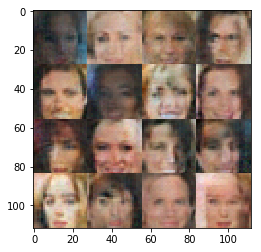

Epoch 3/3... d_loss: 1.3390... g_loss: 0.8332
Epoch 3/3... d_loss: 1.3629... g_loss: 0.7540
Epoch 3/3... d_loss: 1.3080... g_loss: 0.7159


In [ ]:
batch_size = 128
z_dim = 32
learning_rate = 0.0019
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.